In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import tqdm
import os
import matplotlib.pyplot as plt

#tf.keras.backend.set_floatx('float16')

# below code necessary to fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#DTYPE = tf.float16

In [3]:
# load mnist dataset
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # normalize pixel values in range [-1, 1]

In [4]:
BUFFER_SIZE = 60000  # pool size for tensorflow to pull random samples from
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:

def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [7]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # maxout activation function; return max unit
    
    return model

In [8]:
generator = build_generator()
discriminator = build_discriminator()

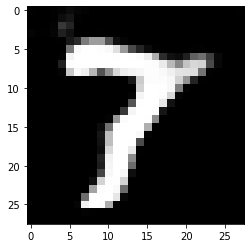

In [21]:
noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)

plt.imshow(generated_img[0, :, :, 0], cmap='gray')

In [9]:
# -1 = fake; 1 = real
discriminator(generated_img)

<tf.Tensor: id=779, shape=(1, 1), dtype=float32, numpy=array([[0.00146959]], dtype=float32)>

In [10]:
# from_logits = True because discriminator returns predictions in range [-1, 1] rather than [0, 1]
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def d_loss(real_output, fake_output):
    
    def random_noise(output):
        return 0.05 * tf.random.uniform(output.shape)
    
    scale = 1 / BATCH_SIZE
    real_loss = cross_entropy(tf.ones_like(real_output) + random_noise(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + random_noise(fake_output), fake_output)
    
    # (1/M) * (cross_entropy loss)
    total_loss = (1 / BATCH_SIZE) * (real_loss + fake_loss)
    return total_loss

In [12]:
def g_loss(fake_output):
    total_loss = (1 / BATCH_SIZE) * cross_entropy(tf.ones_like(fake_output), fake_output)
    return total_loss

In [13]:
gen_opt = tf.keras.optimizers.Adam(1e-4)
dis_opt = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = "./checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=dis_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [15]:
EPOCHS = 50
noise_dim = 100
num_samples = 5

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [22]:
d_metric_loss = tf.keras.metrics.BinaryCrossentropy(name='dis_loss')
g_metric_loss = tf.keras.metrics.BinaryCrossentropy(name='gen_loss')

@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        dis_loss = d_loss(real_output, fake_output)
        gen_loss = g_loss(fake_output)
        
    dis_grads = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    
    dis_opt.apply_gradients(zip(dis_grads, discriminator.trainable_variables))
    gen_opt.apply_gradients(zip(gen_grads, generator.trainable_variables))
    
    
    d_metric_loss(real_output, fake_output)
    g_metric_loss(tf.ones_like(real_output), fake_output)

In [23]:
pbar = tqdm.tqdm(total=EPOCHS)
for e in range(EPOCHS):
    for batch in train_dataset:
        train_step(batch)
    description = "Epoch: {} | gen loss: {} | dis loss: {}".format(e+1, g_metric_loss.result(), d_metric_loss.result())
    
    if (e + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    pbar.set_description(description)
    
    g_metric_loss.reset_states()
    d_metric_loss.reset_states()
    pbar.update(1)

pbar.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 50 | gen loss: 9.71214485168457 | dis loss: 4.994553089141846: 100%|██████████| 50/50 [05:02<00:00,  6.05s/it]  


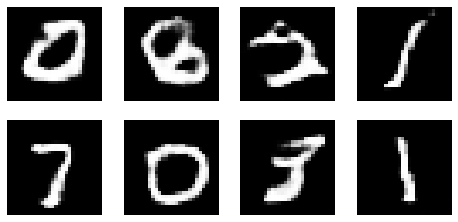

In [34]:
seed = tf.random.normal([8, noise_dim])
predictions = tf.cast(generator(seed, training=False), tf.float32)

fig = plt.figure(figsize=(8,8))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()